In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import scglue
from itertools import chain
import seaborn as sns
import numpy as np
import torch
from IPython import display
import networkx as nx

/home/xuzekai/mambaforge/envs/ATAC_env1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/xuzekai/mambaforge/envs/ATAC_env1/lib/python3.9/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [ ]:
RNA=sc.read_h5ad('/media/AnalysisDisk1/xuzekai/20250715_BMI/ATAC/210_RNA_feature.h5ad')
atac=ad.read_h5ad('/media/AnalysisDisk1/xuzekai/20250715_BMI/ATAC/204_atac_feature.h5ad')

In [5]:
#进行降采样
selected_cells = RNA.obs.groupby("sample").sample(frac=0.5, replace=False).index

# 第二步：子集化 + 立即 copy() 创建真实对象
RNA_1= RNA[selected_cells, :].copy()

In [11]:
scglue.data.get_gene_annotation(RNA_1, gtf = '/media/AnalysisDisk1/xuzekai/20250715_BMI/ATAC/gtf/gencode.v48.annotation.gtf', gtf_by = 'gene_name')

In [12]:
mask = RNA_1.var['chromStart'].notna()  # 返回 pd.Series of True/False, 长度 = 基因数

# 2. 过滤 AnnData：保留所有细胞，只保留满足条件的基因
RNA_filtered = RNA_1[:, mask].copy()

split = atac.var_names.str.split(r"[:-]")
atac.var["chrom"] = split.map(lambda x: x[0])
atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
#atac.var.head()

In [18]:
sc.pp.highly_variable_genes(atac, n_top_genes=20000, batch_key="sample")

/home/xuzekai/mambaforge/envs/ATAC_env1/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:247: RuntimeWarning: invalid value encountered in true_divide
  df["dispersions_norm"] = (


In [19]:
atac

AnnData object with n_obs × n_vars = 1839860 × 338036
    obs: 'sample', 'library', 'barcode', 'cell_type_l1', 'cell_type_l2', 'cell_type_l3', 'cell_type_l4', 'age', 'height', 'weight', 'BMI', 'sex', 'BMI_group', 'blood_type', 'menstruating', 'mood', 'smoking_daily', 'smoking_ststus', 'smoking_history', 'alcohol_weekly', 'drinking_frequency', 'sleep_duration', 'daily_posture', 'exercise_intensity', 'exercise_frequency', 'daily_exercise_duration', 'isolation_date', 'ATAC_expriment'
    var: 'count', 'selected', 'chrom', 'chromStart', 'chromEnd', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'

In [24]:
del RNA_1

In [25]:
import gc

In [26]:
gc.collect() 

8452

In [14]:
#仅根据基因位置和Peak位置进行引导图的构建
guidance= scglue.genomics.rna_anchored_guidance_graph(RNA_filtered, atac)
#会产生highly_variable,如果RNA为高变,对应链接到的peak会多会产生highly_variable,并为Ture

window_graph: 100%|██████████| 23068/23068 [00:11<00:00, 1970.18it/s]


In [15]:
scglue.graph.check_graph(guidance, [RNA_filtered, atac])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [ ]:
scglue.data.lsi (atac,n_components =80,use_highly_variable=True)
#sc.tl.pca(RNA_filtered,n_comps=50)

In [43]:
atac.obsm['X_lsi'] = atac.obsm['X_lsi'][:, 1:]

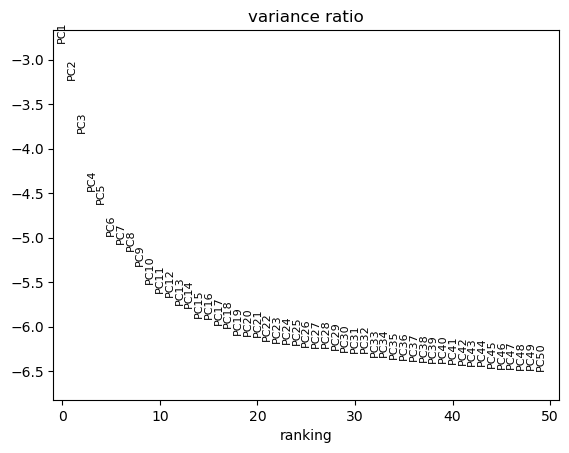

In [21]:
sc.pl.pca_variance_ratio(RNA_filtered, n_pcs=50, log=True)

In [17]:
scglue.models.configure_dataset(atac, "NB", use_batch='sample',use_highly_variable=True, use_rep="X_lsi")
scglue.models.configure_dataset(RNA_filtered, 'NB', use_highly_variable=True, use_layer='counts', use_rep='X_pca',use_batch='sample')
guidance_hvf = guidance.subgraph(chain(
    RNA_filtered.var.query("highly_variable").index,
    atac.var.query("highly_variable").index
)).copy()

In [18]:
glue = scglue.models.fit_SCGLUE(
    {"rna":RNA_filtered, "atac": atac}, guidance_hvf,
    init_kws={'h_dim':512, 'random_seed':666} ,fit_kws={'data_batch_size':2048}
)
glue.save("glue.dill")

NameError: name 'guidance_hvf' is not defined

In [9]:
glue = scglue.models.load_model("/media/AnalysisDisk1/xuzekai/20250715_BMI/ATAC/glue.dill")

[INFO] autodevice: Using CPU as computation device.


In [46]:
dx = scglue.models.integration_consistency(
    glue, {"rna": RNA_filtered, "atac": atac}, guidance_hvf
)
dx

NameError: name 'guidance_hvf' is not defined

In [ ]:
RNA_filtered.X["counts"] = RNA.layers["counts"].copy()

In [ ]:
dx = scglue.models.integration_consistency(
    glue, {"rna": RNA_filtered, "atac": atac}, guidance_hvf
)
dx

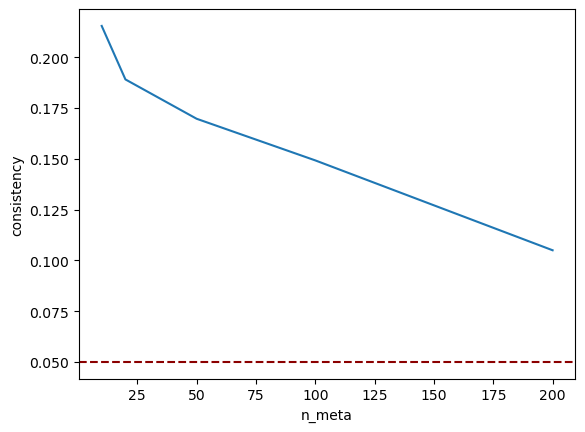

In [20]:
_ = sns.lineplot(x="n_meta", y="consistency", data=dx).axhline(y=0.05, c="darkred", ls="--")

In [45]:
#把细胞的特征加入anndata对象
RNA_filtered.obsm["X_glue"] = glue.encode_data("rna", RNA_filtered)
atac.obsm["X_glue"] = glue.encode_data("atac", atac)

ValueError: Input representation dimensionality 79 does not match the configured 80!

In [ ]:
RNA_filtered.obs['domain'] = 'RNA'
atac.obs['domain'] = 'ATAC'

In [ ]:
combined = ad.concat([RNA_filtered, atac])

In [ ]:
combined_sampling = sc.pp.subsample(combined,fraction=0.1,copy=True)

In [ ]:
sc.pp.neighbors(combined_sampling, n_neighbors=30, use_rep="X_glue",random_state=300)

In [ ]:
sc.tl.umap(combined_sampling,min_dist=0.25)

In [ ]:
sc.pl.umap(combined_sampling , color=["domain"],palette={'ATAC':'#1C3030','RNA':'#7F9B54'},save='1combined.png')

In [55]:
combined_sampling.write_h5ad('/media/AnalysisDisk1/xuzekai/20250715_BMI/ATAC/200_Combined_sampling.h5ad')

In [56]:
feature_embeddings = glue.encode_graph(guidance_hvf)
feature_embeddings = pd.DataFrame(feature_embeddings, index=glue.vertices)
feature_embeddings.iloc[:5, :5]

,0,1,2,3,4
A2M-AS1,-0.001049,0.013710,0.002843,0.000845,0.000617
AAK1,-0.003575,0.020419,0.003279,0.000286,-0.031753
AARD,-0.000093,-0.031262,0.001969,0.001632,-0.000731
AARS2,-0.002688,0.030959,-0.003471,0.000562,-0.065265
AASDH,-0.001507,-0.008060,-0.007110,0.010829,-0.091491


In [61]:
#把基因的特征加入anndata对象
RNA_filtered.varm["X_glue"] = feature_embeddings.reindex(RNA_filtered.var_names).to_numpy()
atac.varm["X_glue"] = feature_embeddings.reindex(atac.var_names).to_numpy()

In [43]:
# 将 artif_dupl 列转为字符串
RNA_filtered.var['artif_dupl'] = RNA_filtered.var['artif_dupl'].astype(str)

In [46]:
RNA_filtered.write("/media/AnalysisDisk1/xuzekai/20250715_BMI/ATAC/rna-emb.h5ad", compression="gzip")
atac.write("/media/AnalysisDisk1/xuzekai/20250715_BMI/ATAC/atac-emb.h5ad", compression="gzip")
nx.write_graphml(guidance_hvf, "/media/AnalysisDisk1/xuzekai/20250715_BMI/ATAC/guidance-hvf.graphml.gz")

In [62]:
RNA_filtered.var["name"] = RNA_filtered.var_names
atac.var["name"] = atac.var_names

In [63]:
genes = RNA_filtered.var.query("highly_variable").index
peaks = atac.var.query("highly_variable").index

In [64]:
features = pd.Index(np.concatenate([RNA_filtered.var_names, atac.var_names]))
feature_embeddings = np.concatenate([RNA_filtered.varm["X_glue"], atac.varm["X_glue"]])

In [65]:
RNA_filtered.var['chromStart'] = RNA_filtered.var['chromStart'].astype(int)
RNA_filtered.var['chromEnd'] = RNA_filtered.var['chromEnd'].astype(int)

In [67]:
skeleton = guidance_hvf.edge_subgraph(
    e for e, attr in dict(guidance_hvf.edges).items()
    if attr["type"] == "fwd"
).copy()

In [68]:
reginf = scglue.genomics.regulatory_inference(
    features, feature_embeddings,
    skeleton=skeleton, random_state=0
)

regulatory_inference: 100%|██████████| 61684/61684 [00:01<00:00, 35960.36it/s]


In [69]:
gene2peak = reginf.edge_subgraph(
    e for e, attr in dict(reginf.edges).items()
    if attr["qval"] < 0.05
)

In [35]:
scglue.genomics.Bed(atac.var).write_bed("peaks.bed", ncols=3)
scglue.genomics.write_links(
    gene2peak,
    scglue.genomics.Bed(RNA_filtered.var).strand_specific_start_site(),
    scglue.genomics.Bed(atac.var),
    "gene2peak.links", keep_attrs=["score"]
)

In [36]:
import pandas as pd

# 提取所有边和属性
edges = []
for u, v, data in gene2peak.edges(data=True):
    edges.append({
        "source": u,
        "target": v,
        "score": data["score"],
        "pval": data["pval"],
        "qval": data["qval"]
    })

df_regulatory = pd.DataFrame(edges)

In [40]:
df_regulatory[df_regulatory['qval']<0.05]['source'].unique()

array(['DUSP4', 'HELB', 'TFPI2', ..., 'FCRL1', 'GLIPR1L2', 'TAF4B'],
      dtype=object)

In [41]:
df_regulatory.to_csv('gene_peak.csv')